# Importing necessary packages

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import random



# Constants(simulation paramaters)

In [105]:
'''
The simulation parameters:

launch_height : initial height above ground in meters
launch_speed :  initial speed of the ball in meters/second.
launch_angle : initial angle of the ball in degrees. 
gravity : Acceleration due to gravity in meters/second^2

'''

launch_height = 10 
launch_speed = 20   
launch_angle = random.randint(30,60)
gravity = 9.81  

# Convert launch angle to radians using the np.radians built in function.
launch_angle_rad = np.radians(launch_angle)

# Calculating the initial velocity component in x and y directions
x0 = 0
y0 = launch_height
vx0 = launch_speed * np.cos(launch_angle_rad)
vy0 = launch_speed * np.sin(launch_angle_rad)


# Intialisation

In [106]:


dt = 0.1  # Time step in seconds (the time span between two observations)
total_time = 5  # Total_time in seconds
time_steps = int(total_time / dt) 

# Initialize arrays to store the true positions of the ball
true_positions = np.zeros((time_steps, 2))

true_positions[0] = [x0, y0] #initial position
random_value = random.randint(0, 10) 
true_positions[0] = [cord + random_value for cord in true_positions[0]] # ball starts within a range of 10 × 10 meters around the real starting position
x0 = true_positions [0][0]
y0 = true_positions[0][1]


true_velocities = np.zeros((time_steps,2))
true_velocities[0] = [vx0,vy0]

# Initialize arrays to store observed positions(true positions with noise) of the ball
observed_positions = np.zeros((time_steps, 2))
observed_positions[0] = true_positions[0] + np.random.normal(0,1) #adding noise to the first position





# Simulating the trajectory of ball

In [107]:
''' 
Simulate the trajectory of the ball:

Calculating the true positions and observed positions:
True positions are calculated using the projectile motion equations.
The observed positions should be erroneous positions over time. So, adding a noise to the true positions will make
it incorrect.
'''

for t in range(1, time_steps):
   
   true_positions[t,0] = true_positions[t-1,0] + true_velocities[t-1,0] * dt
   true_positions[t,1] = true_positions[t-1,1] + true_velocities[t-1,1] * dt - 0.5 * gravity * dt**2
   

   
   true_velocities[t,0] = true_velocities[t-1,0]
   true_velocities[t,1] = true_velocities[t-1,1] - gravity * dt
   
   # Add noise to observations
   observed_positions[t, 0] = true_positions[t, 0] + np.random.normal(0, 1)
   observed_positions[t, 1] = true_positions[t, 1] + np.random.normal(0, 1)


   # Stop the simulation if the ball hits the ground
   if true_positions[t, 1] <= 0:
      true_positions[t, 1] = 0
      observed_positions[t, 1] = 0
      observed_positions = observed_positions[:t+1]
      break

def remove_zero_rows(data):
   return [row for row in data if not all(element == 0 for element in row)]

true_velocities_cleaned = remove_zero_rows(true_velocities)
true_velocities_cleaned = np.array(true_velocities_cleaned)

true_positions_cleaned = remove_zero_rows(true_positions)
true_positions_cleaned = np.array(true_positions_cleaned)
observed_positions_cleaned = remove_zero_rows(observed_positions)
observed_positions_cleaned = np.array(observed_positions_cleaned)



dropping some observations out completely over time intervals

In [108]:
def replace_with_none_over_interval(matrix, start_time, end_time):
   '''
    A function to replace values with None on specific time intervals
    
    Parameters:
    matrix(list of lists) : a 2D list of lists where the values are replaced with None
    start_time, end_time: time intervals
    
    returns
    A list of lists where the values in the time intervals are replaced with 'None' value
   '''
   
   modified_matrix = matrix.copy()
   
   
   for i in range(len(modified_matrix)):
      t = i * dt  # Calculate the current time for the row
      
      if start_time <= t <= end_time:
         modified_matrix[i] = [None, None]  # Replace the row values with None
   return modified_matrix

#intervals
start_time = 1.0
end_time = 1.5

observed_positions_ti = replace_with_none_over_interval(observed_positions_cleaned, start_time= start_time, end_time= end_time)

Kalman filter implementation

In [109]:
'''Intial Parameters of Kalman filter:
               
                A - State tranisition matrix
                H - Observation matrix
                Q - process noise covariance matrix (keeps the covariance matrix from not becoming too small or zero)
                R - Measurement covariance matrix (error in the measurement)
                x - Initial state estimate [x_position, y_position, x_velocity, y_velocity]
                p - Intial error covariance matrix
                B - Control input matrix
                u - Control vector (external inputs)
                w - process noise drawn from N(0,Q)
'''


ax = 0       # No horizontal acceleration
ay = -9.8    # Gravity acting downward

A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Larger Q = high uncertainty and low trust in process model
# Smaller Q = high trust in process model
Q = np.eye(4) * 0.5
Q_dropout = np.eye(4) * 10

R = np.array([[200, 0],
              [0, 200]])

x = np.array([x0, y0, vx0, vy0])
P = np.eye(4) * 10

# Control input matrix (B)
B = np.array([[0.5 * dt**2, 0],
              [0, 0.5 * dt**2],
              [dt, 0],
              [0, dt]])

# Control vector (u), e.g., accelerations in x and y directions
u = np.array([ax, ay])

# Kalman filter function with control input.
def kalman_filter(z, x, P, u):
    '''Calculating the Kalman equations with control input:
       Function returns : the updated state matrix and covariance matrix '''

    if z is not None and not np.any(np.isnan(z)):

        # Predict step
        
        x_pred = A @ x + B @ u   # Predict the next state with control input
        P_pred = A @ P @ A.T + Q  # Predict the next covariance matrix

        # Update step
        y = z - (H @ x_pred)
        S = H @ P_pred @ H.T + R 
        K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain calculation
    
        x_update = x_pred + K @ y  # Update the state estimate
        P_update = (np.eye(4) - K @ H) @ P_pred  # Update the error covariance
    else:
        # Predict step (without measurement update)
        
        x_pred = A @ x + B @ u 
        P_pred = A @ P @ A.T + Q_dropout 
        x_update = x_pred
        P_update = P_pred

    return x_update, P_update


# Run the Kalman Filter function on observed positions to get predicted observations.
estimated_positions = []
estimated_velocities = []
for z in observed_positions_ti:   
    x, P = kalman_filter(z, x, P, u)
    estimated_positions.append(x[:2])  # Append only the first two values (x and y)
    estimated_velocities.append(x[2:4])  # Append only the last two values (vx and vy)

estimated_positions = np.array(estimated_positions)  # Converting estimated positions to numpy array() to plot.
estimated_velocities = np.array(estimated_velocities)  # Converting estimated velocities to numpy array() to plot.


Uncertainty calculation

In [110]:

print('Estimated positions and True positions uncertainty')
differences = np.array(estimated_positions) - np.array(true_positions_cleaned)

mean_difference = np.mean(differences)
std_deviation = np.std(differences)


print(f"Mean: {mean_difference}")
print(f"Standard Deviation (Uncertainty): {std_deviation}")



Estimated positions and True positions uncertainty
Mean: -0.05713725867084629
Standard Deviation (Uncertainty): 0.6559397112644377


In [111]:
# Calculate RMSE
rmse_ball = np.sqrt(np.mean((true_positions_cleaned - estimated_positions) ** 2))


# Display RMSE
print(f"RMSE of Ball: {rmse_ball}")


RMSE of Ball: 0.658423549960125


Plotting the results

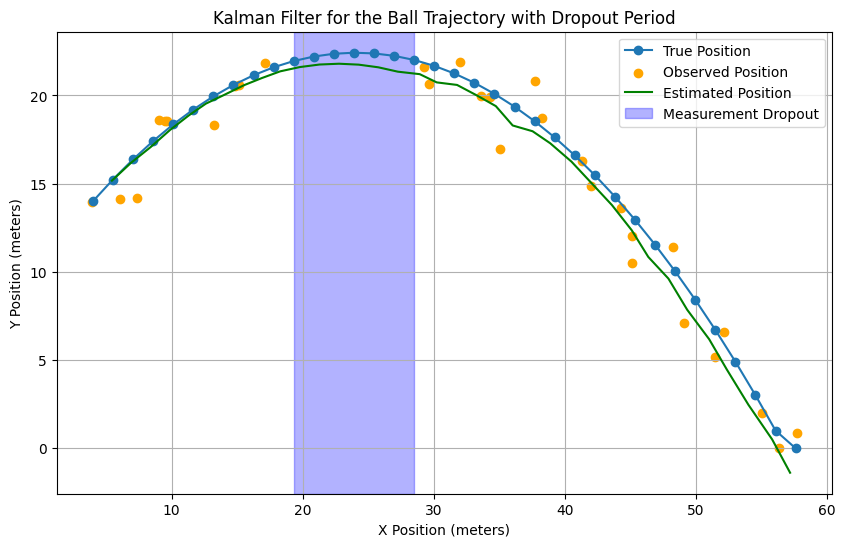

In [112]:
def get_dropout_x_positions(start_time, end_time, dt, true_positions):
    """
    Function to determine X positions for a dropout period.

    Parameters:
    start_time (float): Start of dropout period.
    end_time (float): End of dropout period.
    dt (float): Time step size.
    true_positions (2D array): True positions of the object with X and Y values.

    Returns:
    tuple: X positions (start_x, end_x) corresponding to the dropout period.
    """
    start_step = int(start_time / dt)  # Calculate start time step
    end_step = int(end_time / dt)      # Calculate end time step
    
    start_x = true_positions[start_step, 0]  # X position at start of dropout
    end_x = true_positions[end_step + 1, 0]      # X position at end of dropout
    
    return start_x, end_x



start_x, end_x = get_dropout_x_positions(start_time, end_time, dt, true_positions)

# Plot with dropout region highlighted
plt.figure(figsize=(10, 6))

# Plot the true and observed positions
plt.plot(true_positions_cleaned[:, 0], true_positions_cleaned[:, 1], 'o-', label='True Position')
plt.scatter(observed_positions_ti[:, 0], observed_positions_ti[:, 1], label='Observed Position', color='orange')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], 'g-', label='Estimated Position')

# Highlight the dropout period using X positions
plt.axvspan(start_x, end_x, color='blue', alpha=0.3, label='Measurement Dropout')

plt.xlabel('X Position (meters)')
plt.ylabel('Y Position (meters)')
plt.title('Kalman Filter for the Ball Trajectory with Dropout Period')
plt.legend()
plt.grid(True)
plt.show()


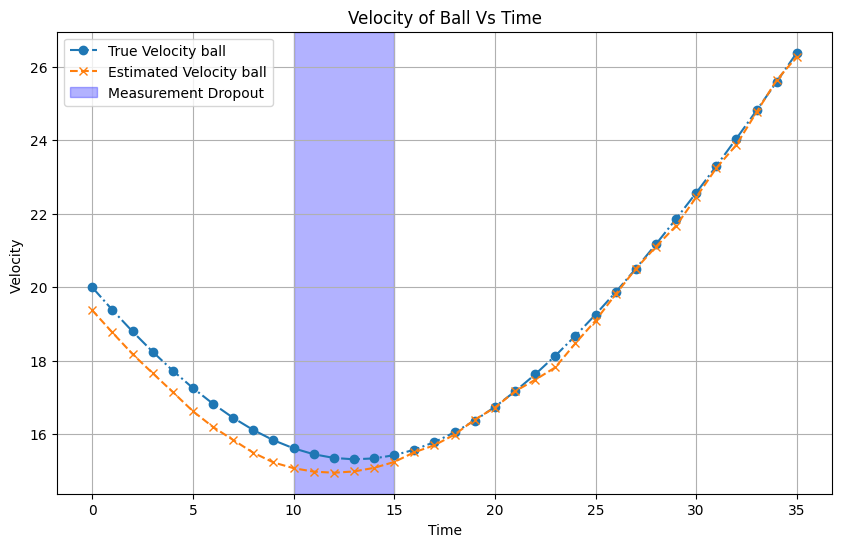

In [113]:
# Calculate velocity (v_xy) for true and estimated velocities
true_velocity_magnitude_ball1 = np.sqrt(true_velocities_cleaned[:, 0]**2 + true_velocities_cleaned[:, 1]**2)
estimated_velocity_magnitude_ball1 = np.sqrt(estimated_velocities[:, 0]**2 + estimated_velocities[:, 1]**2)

plt.figure(figsize=(10, 6))

# Velocity magnitude plots
plt.plot(range(len(true_velocity_magnitude_ball1)), true_velocity_magnitude_ball1, label='True Velocity ball', linestyle='-.', marker='o')
plt.plot(range(len(estimated_velocity_magnitude_ball1)), estimated_velocity_magnitude_ball1, label='Estimated Velocity ball', linestyle='--', marker='x')
plt.axvspan(start_time/dt, end_time / dt, color='blue', alpha=0.3, label='Measurement Dropout')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Velocity ')
plt.title('Velocity of Ball Vs Time')
plt.grid(True)
plt.show()

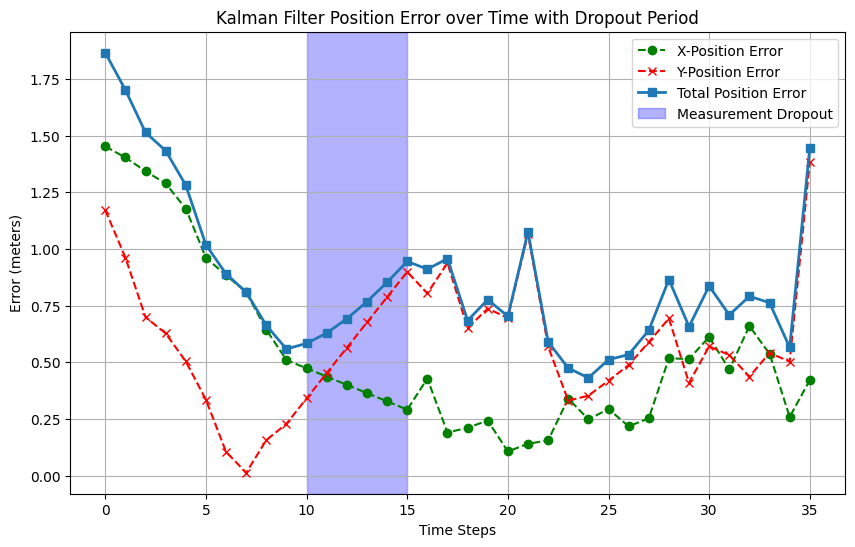

In [114]:


# Compute errors (Euclidean distance)
error_x = np.abs(true_positions_cleaned[:, 0] - estimated_positions[:, 0])  # X-position error
error_y = np.abs(true_positions_cleaned[:, 1] - estimated_positions[:, 1])  # Y-position error
total_error = np.sqrt(error_x**2 + error_y**2)  # Total Euclidean error

# Plot the errors
plt.figure(figsize=(10, 6))



# Add the previous plot code (your error lines)
plt.plot(range(len(true_positions_cleaned)), error_x, label='X-Position Error',linestyle ='--',marker='o',color ="green")
plt.plot(range(len(true_positions_cleaned)), error_y, label='Y-Position Error', linestyle ='--',marker='x',color='red')
plt.plot(range(len(true_positions_cleaned)), total_error, label='Total Position Error', linestyle='-',marker='s', linewidth=2)
plt.axvspan(start_time/dt, end_time / dt, color='blue', alpha=0.3, label='Measurement Dropout')


# Final touches
plt.title('Kalman Filter Position Error over Time with Dropout Period')
plt.xlabel('Time Steps')
plt.ylabel('Error (meters)')
plt.legend()
plt.grid(True)
plt.show()
